# A specific hourglass plots with MAF

In [98]:
import warnings
import urllib
from os import path
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from matplotlib.patches import Patch

import astropy.coordinates
import astropy.time
from astropy import units as u

from rubin_sim import maf
import rubin_sim.maf.db
import rubin_sim.maf.metricBundles
from rubin_sim.utils.riseset import riseset_times

### Suppress useless warnings

In [2]:
warnings.filterwarnings('ignore', append=True, message=r'.*Tried to get polar motions for times after IERS data is valid.*')
warnings.filterwarnings('ignore', append=True, message=r'.*dubious year.*')

### Configuration

In [4]:
data_dir = '.'

In [5]:
opsim_origin = '/Users/lynnej/opsim/fbs_1.7.1/new_rolling/baseline_nexp2_v1.7.1_10yrs.db'
#opsim_origin = 'https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.7/baseline/baseline_nexp2_v1.7_10yrs.db'
maf_output_dir = path.join(data_dir, 'maf_output')

## Get input and output database connections

In [7]:
ops_db = maf.db.OpsimDatabase(opsim_fname)
results_db = maf.db.ResultsDb(outDir=maf_output_dir)

## Make new version of the UseMetric and HourglassPlotter ##

In [153]:
# This could have been the Pass metric instead .. (just returns the values in a given set of columns)
class FilterUseMetric(maf.metrics.BaseMetric):
    """Metric to classify visits by filter"""

    def __init__(self, filterCol='filter', **kwargs):
        self.filterCol = filterCol
        super().__init__(col=[filterCol], metricDtype="object", **kwargs)

    def run(self, dataSlice, slicePoint=None):  # pylint: disable=invalid-name
        """Run the metric.

        Parameters
        ----------
        dataSlice : numpy.NDarray
           Values passed to metric by the slicer, which the metric will use to calculate
           metric values at each slicePoint.
        slicePoint : Dict
           Dictionary of slicePoint metadata passed to each metric.
           E.g. the ra/dec of the healpix pixel or opsim fieldId.

        Returns
        -------
        str
            use at each slicePoint.
        """
        return dataSlice[self.filterCol]

In [145]:
class MonthHourglassFilterPlot(maf.plots.TimeUseHourglassPlotMixin, maf.plots.MonthHourglassPlot):
    """Plot categorical 'use' data for one month."""
    def __init__(self, *args, **kwargs):
        """Update some of the default plotDict information # remove transit lines for DDFs"""
        super().__init__(*args, **kwargs)
        self.objectPlotter = True # pylint: disable=invalid-name
        self.plotType = "Use" + self.plotType # pylint: disable=invalid-name
        self.defaultPlotDict["cmap"] = plt.get_cmap("tab10")
        self.defaultPlotDict["legend"] = True
        self.defaultPlotDict["legend_ncols"] = 2
        self.defaultPlotDict["assign_colors"] = OrderedDict()
        self.marked_ra = {}
        self.legend_elements = []
        
    def _map_colors(self, values, plotDict): # pylint: disable=invalid-name
        """Override the basic map color choices to use categorical information."""
        cmap = plotDict["cmap"]
        self.color_map = {}
        if len(self.color_map.keys()) == 0:
            self.color_map = _assign_use_colors(np.unique(values), cmap, 
                                                assign_colors=plotDict['assign_colors'])

        colors = np.array(np.vectorize(self.color_map.get)(values)).T.tolist()
        color_mappable = None

        return colors, color_mappable
    
    def _plot_value_bars(self, values, night_mjds, hours_after_midnight,
                         duration, epoch_mjd, plotDict, ax):
        """Add the color bar blocks for the metric values."""
        # Find the colors to be used.
        colors, color_mappable = self._map_colors(values, plotDict)
        # Add the bars.
        ax.bar(
            hours_after_midnight,
            height=0.8,
            width=duration,
            linewidth=0,
            bottom=night_mjds - epoch_mjd - 0.4,
            color=colors,
            align="edge",
        )
        # Add items for legend (so only one copy)
        for color in self.color_map:
            p = Patch(facecolor=self.color_map[color], label=color)
            self.legend_elements.append(p)
        return color_mappable
    
    def _astron_hourglass(self, start_mjd, end_mjd, ax,
                          site, solar_time):  # pylint: disable=invalid-name, too-many-locals, too-many-branches
        """Add the night and twilight start/end lines, add the moon transit lines"""
        mjds = np.arange(start_mjd, end_mjd + 1, 1)
        start_mjd = mjds[0]

        # Moon transit

        cal_night_mjds = mjds - site.lon.deg / 360

        moon_transit_mjds = _compute_moon_transit_mjds(cal_night_mjds, site)

        if solar_time:
            (moon_transit_nights, moon_transit_hams) = _compute_hours_after_solar_midnight(moon_transit_mjds,
                                                                                           site)
        else:
            moon_transit_nights, moon_transit_hams = _compute_hours_after_midnight(moon_transit_mjds)
        # Loop to avoid wrapping
        moon_lines = np.cumsum(
            np.diff(moon_transit_hams, prepend=moon_transit_hams[0]) < 0
        )
        moon_label = "moon"
        for moon_line in np.unique(moon_lines):
            these_hams = moon_transit_hams[moon_lines == moon_line]
            these_nights = moon_transit_nights[moon_lines == moon_line]
            ax.plot(
                these_hams,
                these_nights - start_mjd + 1,
                color="yellow",
                linewidth=8,
                alpha=0.5,
                label=moon_label,
            )
            moon_label = None
        self.legend_elements.append(Patch(facecolor='yellow', label='Moon'))
            
        # Moon rise and set
        for direction in ("up", "down"):
            moon_event_mjds = riseset_times(
                cal_night_mjds, direction, alt=0, body="moon"
            )
            if solar_time:
                (
                    moon_event_nights,
                    moon_event_hams,
                ) = _compute_hours_after_solar_midnight(moon_event_mjds, site)
            else:
                moon_event_nights, moon_event_hams = _compute_hours_after_midnight(
                    moon_event_mjds
                )
            # Loop to avoid wrapping
            moon_lines = np.cumsum(
                np.diff(moon_event_hams, prepend=moon_event_hams[0]) < 0
            )
            for moon_line in np.unique(moon_lines):
                these_hams = moon_event_hams[moon_lines == moon_line]
                these_nights = moon_event_nights[moon_lines == moon_line]
                ax.plot(
                    these_hams,
                    these_nights - start_mjd + 1,
                    color="yellow",
                    linestyle="dotted",
                )

        # Twilight
        guess_offset = {"up": 0.2, "down": -0.2}
        twilight_shade = {0: "0.7", -6: "0.6", -12: "0.4", -18: "black"}

        for alt in twilight_shade:
            pm_event_mjds = riseset_times(
                cal_night_mjds + guess_offset["down"], "down", alt=alt, body="sun"
            )
            am_event_mjds = riseset_times(
                cal_night_mjds + guess_offset["up"], "up", alt=alt, body="sun"
            )
            if solar_time:
                (
                    pm_event_nights,
                    pm_event_hams,
                ) = _compute_hours_after_solar_midnight(pm_event_mjds, site)
                (
                    am_event_nights,
                    am_event_hams,
                ) = _compute_hours_after_solar_midnight(am_event_mjds, site)
            else:
                (
                    pm_event_nights,
                    pm_event_hams,
                ) = _compute_hours_after_midnight(pm_event_mjds)
                (
                    am_event_nights,
                    am_event_hams,
                ) = _compute_hours_after_midnight(am_event_mjds)
            assert np.array_equal(am_event_nights, pm_event_nights)
            ax.fill_betweenx(
                am_event_nights - start_mjd + 1,
                pm_event_hams,
                am_event_hams,
                color=twilight_shade[alt],
                zorder=-10,
            )

        return ax    
    
    def _plot_on_axis(self, intervals, ax, epoch_mjd=None, plotDict=None):  # pylint: disable=invalid-name
        """Actually add the data into the month/hour plot - includes adding the twilight/transit lines."""
        if plotDict is None:
            plotDict = {}

        # Add the 'block' data
        if len(intervals) > 0:
            if self.solar_time:
                (night_mjds, hours_after_midnight) = \
                    _compute_hours_after_solar_midnight(intervals["mjd"].values, self.site)
            else:
                (night_mjds, hours_after_midnight) = _compute_hours_after_midnight(intervals["mjd"].values)
            # Put in the blocks
            color_mappable = self._plot_value_bars(
                intervals["value"],
                night_mjds,
                hours_after_midnight,
                intervals["duration"],
                epoch_mjd,
                plotDict,
                ax,
            )
        else:
            color_mappable = None

        try:
            ax.set_ylim(plotDict["yMax"], plotDict["yMin"])
        except KeyError:
            ax.set_ylim(ax.get_ylim()[-1] + 1, -0.5)
        ax.set_xlim(plotDict["xMin"], plotDict["xMax"])

        start_mjd = ax.get_ylim()[1] + epoch_mjd
        end_mjd = ax.get_ylim()[0] + epoch_mjd
        # Add the twilight boundaries and moon transit lines
        self._astron_hourglass(
            start_mjd + 0.5, end_mjd + 1, ax, self.site, self.solar_time
        )
        # Add the transits
        self._plot_transits(start_mjd + 0.5, end_mjd + 1, ax)

        return color_mappable
    
    def _add_axis_labels(self, ax, plotDict):  # pylint: disable=invalid-name, no-self-use
        """Add axis labels to the title/x/y axes of the main plot"""
        ax.set_title(plotDict["title"], fontsize='x-large')
        ax.set_xlabel(plotDict["xlabel"], fontsize='x-large')
        ax.set_ylabel(plotDict["ylabel"], fontsize='x-large')

    
    def __call__(self, metricValue, slicer, userPlotDict, fignum=None):
        """Identify the interval of metric data to use and plot it with the relevant class._plot function"""
        intervals = pd.DataFrame(
            {
                "mjd": slicer.slicePoints["mjd"],
                "duration": (slicer.slicePoints["duration"] * u.s).to_value(
                    u.hour  # pylint: disable=no-member
                ),
                "value": metricValue,
            }
        )
        # Set up a copy of the plot dict to contain entries relevant for this plot
        plotDict = copy.copy(  # pylint: disable=invalid-name
            self.defaultPlotDict
        )
        plotDict.update(userPlotDict)
        # Generate the figure
        fig = plt.figure(fignum, figsize=plotDict["figsize"])
        # Add the plots
        color_mappable, axes = self._plot(fig, intervals, plotDict)
        # Add a colorbar
        if color_mappable is not None:
            self._add_colorbar(fig, color_mappable, axes, plotDict)
        # Add the legend -- contents of the legend are set by the 'labels' used when adding the
        # blocks or transit lines.  (note that typically blocks do not have labels).
        if plotDict["legend"] and len(self.color_map) > 0:
            handles = self.legend_elements
            fig.legend(
                handles=handles,
                #labels=labels,
                loc=plotDict["legend_loc"],
                ncol=plotDict["legend_ncols"],
                bbox_to_anchor=plotDict["legend_bbox_to_anchor"],
            )
        return fig.number

    
def _assign_use_colors(uses, cmap, assign_colors=OrderedDict(), use_colors=OrderedDict()):
    """Set a dictionary of nice colors for the use blocks."""
    available_idxs = list(range(cmap.N))

    used_colors = set(use_colors.values())
    for cmap_idx in range(cmap.N):
        # Skip gray because it is confusing against background
        this_cmap = cmap(cmap_idx)
        if this_cmap[0] == this_cmap[1] and this_cmap[0] == this_cmap[2]:
            available_idxs.remove(cmap_idx)

        # If a color has been used already, don't reuse it for something else
        if cmap(cmap_idx) in used_colors:
            available_idxs.remove(cmap_idx)
            
    use_color_idx = assign_colors

    for use, cmap_idx in use_color_idx.items():
        if cmap_idx in available_idxs:
            available_idxs.remove(cmap_idx)
            use_colors[use] = cmap(cmap_idx)
        else:
            assert use_colors[use] == cmap(cmap_idx)

    for use in uses:
        if use not in use_colors:
            use_idx = available_idxs[0]
            use_colors[use] = cmap(use_idx)
            available_idxs.remove(use_idx)

    return use_colors

In [128]:
# These functions for transit and hours away from midnight times could be made general utilities
def _compute_hours_after_midnight(mjd, tz="Chile/Continental"):  # pylint: disable=invalid-name
    """Calculate the 'hours' value for the hourglass plot, when ignoring solar midnight (and thus site)"""
    utc_datetimes = pd.to_datetime(mjd + 2400000.5, unit="D", origin="julian").tz_localize("UTC")
    local_times = pd.DatetimeIndex(utc_datetimes).tz_convert(tz)
    night_mjds = (
        np.floor(local_times.to_julian_date() - 2400001).astype(int).values
    )
    hours_after_midnight = (
        local_times.to_julian_date().values - 2400001.5 - night_mjds
    ) * 24
    return night_mjds, hours_after_midnight


def _compute_hours_after_solar_midnight(mjd, site,
                                        tz="Chile/Continental"):  # pylint: disable=invalid-name
    """Calculate the 'hours' value for the hourglass plot, when looking for hours around solar midnight."""
    times = astropy.time.Time(mjd, format="mjd", location=site)
    mean_solar_jd = times.ut1.mjd + site.lon.deg / 360
    mean_solar_time = astropy.coordinates.Angle(
        mean_solar_jd * 360, unit=u.deg  # pylint: disable=no-member
    ).wrap_at(
        180 * u.deg  # pylint: disable=no-member
    )
    hours_after_midnight = (
        mean_solar_time.to_value(u.deg)
        * 24
        / 360.0  # pylint: disable=no-member
    )  # pylint: disable=no-member
    utc_datetimes = pd.to_datetime(
        mjd + 2400000.5, unit="D", origin="julian"
    ).tz_localize("UTC")
    local_times = pd.DatetimeIndex(utc_datetimes).tz_convert(tz)
    night_mjds = (
        np.floor(local_times.to_julian_date() - 2400001).astype(int).values
    )
    return night_mjds, hours_after_midnight


def _compute_coord_transit_mjds(mjds, ra, site):  # pylint: disable=invalid-name
    """Compute the coordinate transit times, for transit lines for the hourglass plot"""
    # Calculate the local sidereal time at mjds - in degrees (for RA comparison)
    lsts = astropy.time.Time(mjds, format="mjd", location=site).sidereal_time("apparent").deg
    ha = astropy.coordinates.Angle(lsts - ra, unit=u.deg).wrap_at(180 * u.deg)
    mjds = mjds - ha.to_value(u.deg) / 360
    return mjds


def _compute_moon_transit_mjds(mjds, site):
    """Compute the transit times for the moon, for transit lines for the hourglass plot"""
    for _ in np.arange(3):
        times = astropy.time.Time(mjds, format="mjd", location=site)
        moon_coords = astropy.coordinates.get_moon(times)
        # Calculate the local sidereal time at mjds
        lsts = astropy.time.Time(mjds, format="mjd", location=site).sidereal_time("apparent")
        ha = (lsts - moon_coords.ra).wrap_at(180 * u.deg)
        mjds = mjds - ha.to_value(u.deg) / 360
    return mjds


In [44]:
bundle = maf.metricBundles.MetricBundle(metric=FilterUseMetric(),
                                        slicer=maf.slicers.VisitIntervalSlicer(),
                                        constraint='night < 600',
                                        plotDict={'title': "Filter usage for October, 2023"},
                                        plotFuncs=[MonthHourglassFilterPlot(10, 2023)])

bundle_group = maf.metricBundles.MetricBundleGroup({'FUse': bundle}, ops_db, 
                                                   maf_output_dir, results_db) 
bundle_group.runAll()

Querying database SummaryAllProps with constraint night < 500 for columns ['filter', 'visitTime', 'observationStartMJD']
Found 280899 visits
Running:  ['FUse']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [45]:
print(len(bundle.metricValues))
bundle.metricValues.data[0:10]

280899


array(['i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i'], dtype=object)

In [144]:
np.unique((bundle.slicer.slicePoints["duration"] * u.s).to_value(u.hour))

array([0.00944444])

It's worth noting that the metric values contain the output of the UseMetric ONLY, so when picking out dates below in the plotter -- they are coming from the slicePoints.

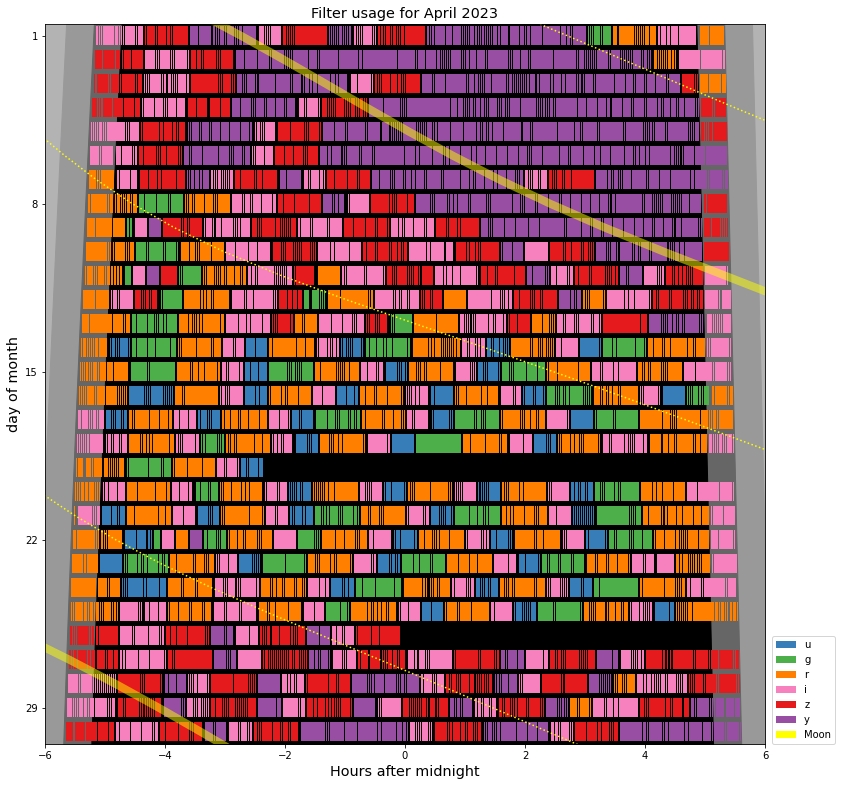

In [148]:
ph = maf.plots.PlotHandler(dpi=270)
ph.setMetricBundles([bundle])
cmap = plt.get_cmap('Set1')
filter_colors = OrderedDict([('u', 1), ('g', 2), ('r', 4), ('i', 7), ('z', 0), ('y', 3)])
ph.plot(plotFunc=MonthHourglassFilterPlot(4, 2023), 
        plotDicts={'cmap': cmap, 'assign_colors': filter_colors, 
                   'legend_ncols': 1, 
                   'legend_loc': (1.01, 0.5), 'legend_bbox_to_anchor': (1.01, 0.0),
                  'title': "Filter usage for April 2023", 'figsize': (10, 10)})

1

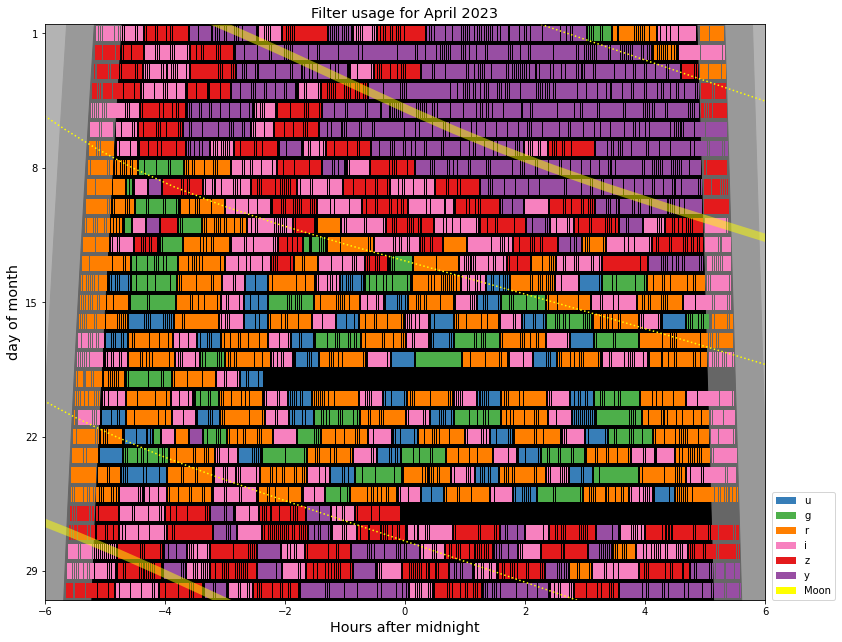

In [151]:
ph = maf.plots.PlotHandler(dpi=270, figformat='png')
ph.setMetricBundles([bundle])
cmap = plt.get_cmap('Set1')
filter_colors = OrderedDict([('u', 1), ('g', 2), ('r', 4), ('i', 7), ('z', 0), ('y', 3)])
ph.plot(plotFunc=MonthHourglassFilterPlot(4, 2023), 
        plotDicts={'cmap': cmap, 'assign_colors': filter_colors, 
                   'legend_ncols': 1, 
                   'legend_loc': (1.01, 0.5), 'legend_bbox_to_anchor': (1.01, 0.0),
                  'title': "Filter usage for April 2023", 'figsize': (10, 8)})

In [114]:
bundle2 = maf.metricBundles.MetricBundle(metric=maf.metrics.UseMetric(),
                                        slicer=maf.slicers.BlockIntervalSlicer(),
                                        constraint='night < 600',
                                        plotDict={'title': "Filter usage for April, 2023"},
                                        plotFuncs=[MonthHourglassFilterPlot(4, 2023)])
bundle_group = maf.metricBundles.MetricBundleGroup({'use': bundle2}, ops_db, 
                                                   outDir=maf_output_dir, resultsDb=results_db)
bundle_group.runAll()

Querying database SummaryAllProps with constraint night < 600 for columns ['note', 'visitTime', 'observationStartMJD']
Found 324017 visits
Running:  ['use']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [118]:
np.unique(bundle2.metricValues.data)

array(['COSMOS', 'ECDFS', 'EDFS', 'ELAISS1', 'XMM-LSS', 'greedy',
       'wide with only IR', 'wide with u, g, or r'], dtype=object)

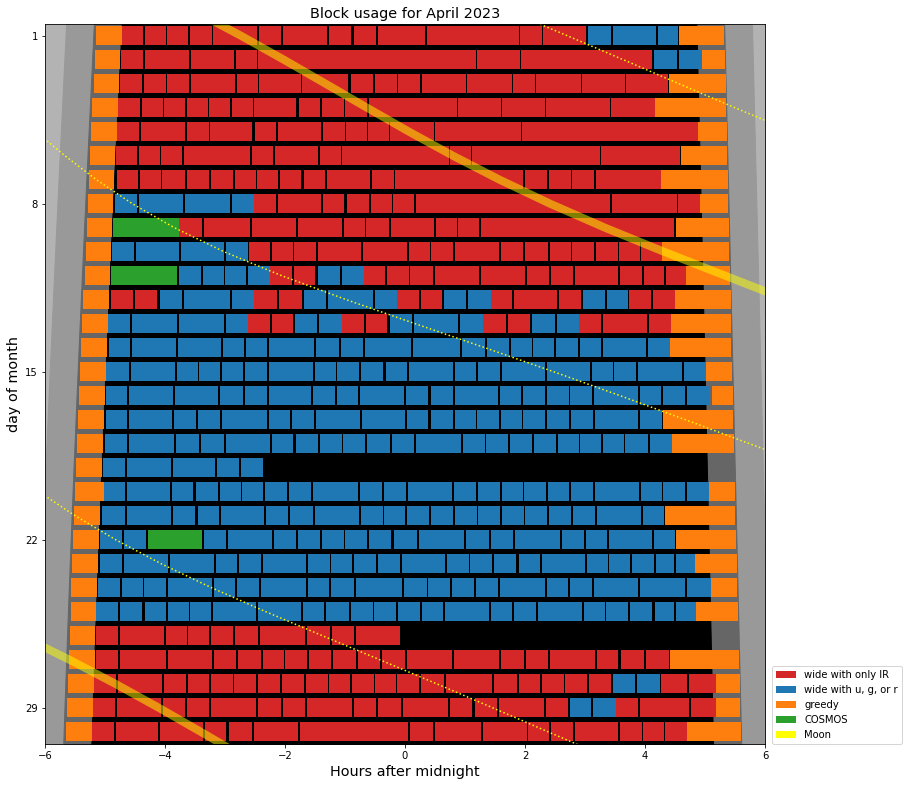

In [130]:
ph = maf.plots.PlotHandler()
ph.setMetricBundles([bundle2])
cmap10 = plt.get_cmap('tab10')
block_colors = OrderedDict((("wide with only IR", 3), ("wide with u, g, or r", 0), ("greedy", 1),))
                           
ph.plot(plotFunc=MonthHourglassFilterPlot(4, 2023), 
        plotDicts={'cmap': cmap10, 'assign_colors': block_colors,
                   'legend_ncols': 1, 
                   'legend_loc': (1.01, 0.5), 'legend_bbox_to_anchor': (1.01, 0.0),
                  'title': "Block usage for April 2023", 'figsize': (10, 10)})
plt.savefig('hg_blocks.png')